# Declarations

In [104]:
#!/usr/bin/python
import sys
from time import time
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from backports import tempfile
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from tester import dump_classifier_and_data
sys.path.append('../tools/')
from feature_format import featureFormat, targetFeatureSplit

# Task 0: Load and explore the dataset

## 1. Load the dataset

In [105]:
# Load the dictionary containing the dataset
file = open('final_project_dataset.pkl', 'r')
enron_data = pickle.load(file)
file.close()

## 2. Clean and put the data in a DataFrame

In [106]:
pd.options.display.float_format = '{:20,.2f}'.format
enron_data_frame = DataFrame.from_dict(enron_data, orient='index')
enron_data_frame.drop('TOTAL', axis=0, inplace=True)
# All NaN strings are converted to Numpy nan values, which allows the
# describe function to produce proper numeric values for all statistics.
enron_data_frame.replace('NaN', np.NaN, regex=True, inplace=True)
# Convert True to 1 and False to 0.
enron_data_frame.replace({True: 1, False: 0}, inplace=True)
enron_data_frame.drop('email_address', axis=1, inplace=True)
print('Enron data point count: {}\n'.format(len(enron_data_frame)))
enron_data_frame.head()

Enron data point count: 145



,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,"201,955.00","2,902.00","2,869,717.00","4,484,442.00","1,729,541.00","4,175,000.00","126,027.00","1,407.00","-126,027.00","1,729,541.00","13,868.00",nan,"2,195.00",152.00,65.00,0,nan,"-3,081,055.00","304,805.00",47.00
BADUM JAMES P,nan,nan,"178,980.00","182,466.00","257,817.00",nan,nan,nan,nan,"257,817.00","3,486.00",nan,nan,nan,nan,0,nan,nan,nan,nan
BANNANTINE JAMES M,477.00,566.00,nan,"916,197.00","4,046,157.00",nan,"1,757,552.00",465.00,"-560,222.00","5,243,487.00","56,301.00",nan,29.00,"864,523.00",0.00,0,nan,"-5,104.00",nan,39.00
BAXTER JOHN C,"267,102.00",nan,"1,295,738.00","5,634,343.00","6,680,544.00","1,200,000.00","3,942,714.00",nan,nan,"10,623,258.00","11,200.00",nan,nan,"2,660,303.00",nan,0,nan,"-1,386,055.00","1,586,055.00",nan
BAY FRANKLIN R,"239,671.00",nan,"260,455.00","827,696.00",nan,"400,000.00","145,796.00",nan,"-82,782.00","63,014.00","129,142.00",nan,nan,69.00,nan,0,nan,"-201,641.00",nan,nan


## 3. DataFrame info

In [107]:
enron_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
salary                       94 non-null float64
to_messages                  86 non-null float64
deferral_payments            38 non-null float64
total_payments               124 non-null float64
exercised_stock_options      101 non-null float64
bonus                        81 non-null float64
restricted_stock             109 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    17 non-null float64
total_stock_value            125 non-null float64
expenses                     94 non-null float64
loan_advances                3 non-null float64
from_messages                86 non-null float64
other                        92 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          145 non-null int64
director_fees                16 non-null float64
deferred_income              48 non-null floa

## 4. DataFrame description

In [108]:
enron_data_frame.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,94.00,86.00,38.00,124.00,101.00,81.00,109.00,86.00,17.00,125.00,94.00,3.00,86.00,92.00,86.00,145.00,16.00,48.00,65.00,86.00
mean,"284,087.54","2,073.86","841,602.53","2,623,421.18","2,959,559.26","1,201,773.07","1,147,424.09","1,176.47","621,892.82","3,352,073.02","54,192.01","27,975,000.00",608.79,"465,276.66",41.23,0.12,"89,822.88","-581,049.81","746,491.20",64.90
std,"177,131.12","2,582.70","1,289,322.63","9,488,105.53","5,499,449.60","1,441,679.44","2,249,770.36","1,178.32","3,845,528.35","6,532,883.10","46,108.38","46,382,560.03","1,841.03","1,389,719.06",100.07,0.33,"41,112.70","942,076.40","862,917.42",86.98
min,477.00,57.00,"-102,500.00",148.00,"3,285.00","70,000.00","-2,604,490.00",2.00,"-1,787,380.00","-44,093.00",148.00,"400,000.00",12.00,2.00,0.00,0.00,"3,285.00","-3,504,386.00","69,223.00",0.00
25%,"211,802.00",541.25,"79,644.50","386,380.25","506,765.00","425,000.00","252,055.00",249.75,"-329,825.00","494,136.00","22,479.00","1,200,000.00",22.75,"1,209.00",1.00,0.00,"83,674.50","-611,209.25","275,000.00",10.00
50%,"258,741.00","1,211.00","221,063.50","1,100,246.50","1,297,049.00","750,000.00","441,096.00",740.50,"-140,264.00","1,095,040.00","46,547.50","2,000,000.00",41.00,"51,984.50",8.00,0.00,"106,164.50","-151,927.00","422,158.00",35.00
75%,"308,606.50","2,634.75","867,211.25","2,084,662.75","2,542,813.00","1,200,000.00","985,032.00","1,888.25","-72,419.00","2,606,763.00","78,408.50","41,762,500.00",145.50,"357,577.25",24.75,0.00,"112,815.00","-37,926.00","831,809.00",72.25
max,"1,111,258.00","15,149.00","6,426,990.00","103,559,793.00","34,348,384.00","8,000,000.00","14,761,694.00","5,521.00","15,456,290.00","49,110,078.00","228,763.00","81,525,000.00","14,368.00","10,359,729.00",609.00,1.00,"137,864.00",-833.00,"5,145,434.00",528.00


## 5. Missing values analysis

In [109]:
missing_values = enron_data_frame.isna().sum()
missing_values_percentage = 100 * missing_values / len(enron_data_frame)
missing_values_table = pd.concat([missing_values,
                                    missing_values_percentage], axis=1)
# Rename the columns.
missing_values_table = missing_values_table.rename(
                    columns={0: 'Missing Values', 1: '% of Total Values'})
# Leave on the table only the columns that are missing values.
columns_missing_values = missing_values_table.iloc[:, 1] != 0
missing_values_table = missing_values_table[columns_missing_values]
# Sort the table by percentage of missing descending.
missing_values_table = missing_values_table.sort_values(
                            '% of Total Values', ascending=False).round(1)
# Print some summary information.
print('Columns in dataframe: {}.'.format(enron_data_frame.shape[1]))
print('Columns missing values: {}.'.format(missing_values_table.shape[0]))
missing_values_table

Columns in dataframe: 20.
Columns missing values: 19.


,Missing Values,% of Total Values
loan_advances,142,97.90
director_fees,129,89.00
restricted_stock_deferred,128,88.30
deferral_payments,107,73.80
deferred_income,97,66.90
long_term_incentive,80,55.20
bonus,64,44.10
from_poi_to_this_person,59,40.70
shared_receipt_with_poi,59,40.70
to_messages,59,40.70


## 6. Correlation report

Text(0.5,1,'Correlation Heatmap')

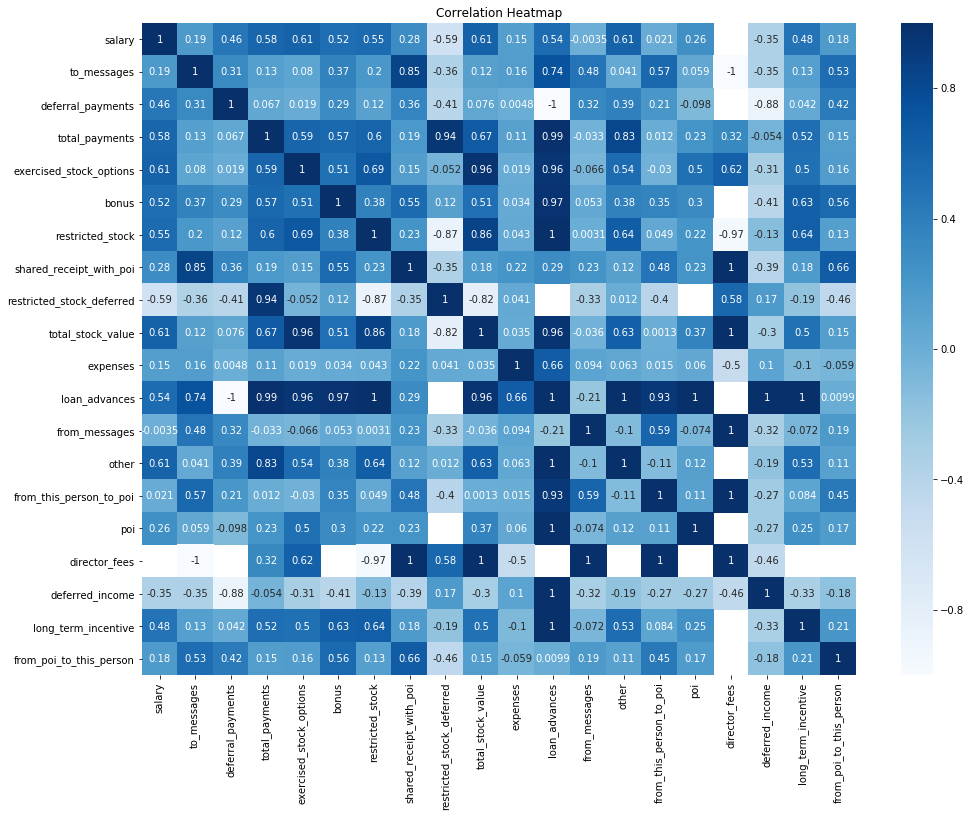

In [110]:
correlations_table = enron_data_frame.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlations_table, cmap='Blues', annot=True)
plt.title('Correlation Heatmap')

## 7. Label feature exploration

Label value counts:
0    127
1     18
Name: poi, dtype: int64



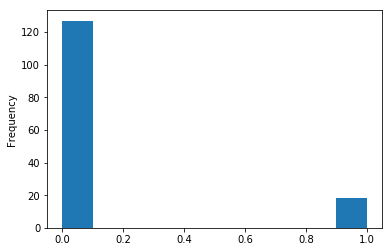

In [111]:
label_column_name = 'poi'
label_column = enron_data_frame[label_column_name]
print('Label value counts:\n{}\n'.format(label_column.value_counts()))
label_column.astype(int).plot.hist()

## 8. Correlations to target feature

In [112]:
# Find correlations with the target and sort.
target_correlations = correlations_table[label_column_name].sort_values()
# Display correlations tables.
print('Most positive correlations to ({}) feature:'.format(label_column_name))
display(target_correlations.tail())

print('Most negative correlations to ({}) feature:'.format(label_column_name))
display(target_correlations.head())

Most positive correlations to (poi) feature:


exercised_stock_options                     0.50
loan_advances                               1.00
poi                                         1.00
restricted_stock_deferred                    nan
director_fees                                nan
Name: poi, dtype: float64

Most negative correlations to (poi) feature:


deferred_income                    -0.27
deferral_payments                  -0.10
from_messages                      -0.07
to_messages                         0.06
expenses                            0.06
Name: poi, dtype: float64

# Task 1: Select what features you'll use.

## 1. Define the full feature list

In [113]:
enron_feature_list = ['poi', 'salary', 'deferral_payments', 'total_payments',
                      'loan_advances', 'bonus', 'restricted_stock_deferred', 
                      'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 'long_term_incentive', 
                      'restricted_stock', 'director_fees', 'to_messages',
                      'from_poi_to_this_person', 'from_messages', 
                      'from_this_person_to_poi', 'shared_receipt_with_poi']

enron_data.pop('TOTAL', 0)
data = featureFormat(enron_data, enron_feature_list, sort_keys=True)
labels, features = targetFeatureSplit(data)
labels = np.array(labels)
features = np.array(features)


# Task 2: Remove outliers

# Task 3: Create new feature(s)

# Task 4: Try a variety of classifiers
Please name your classifier clf for easy export below. Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html

## 1. Define the pipelines to explore

In [114]:
scale_variations = [None, RobustScaler(), MinMaxScaler(), Normalizer()]
reduce_dim_variations = [None, PCA(2), PCA(4), PCA(8), PCA(16)]
pipelines = {
    'GaussianNB': [{
        'classify': [GaussianNB()],
        'scale': scale_variations,
        'reduce_dim': reduce_dim_variations
    }],
    'DecisionTreeClassifier': [{
        'classify': [DecisionTreeClassifier(random_state=42)],
        'scale': scale_variations,
        'reduce_dim': reduce_dim_variations,
        'classify__criterion': ['entropy', 'gini'],
        'classify__splitter': ['best', 'random'],
        'classify__min_samples_split': [2, 4, 8, 16, 32, 64]
    }],
    # I wasn't able to make SVC work with the 'linear' kernel.
    'SVC': [{
        'classify': [SVC(random_state=42)],
        'scale': scale_variations,
        'reduce_dim': reduce_dim_variations,
        'classify__kernel': ['rbf'],
        'classify__gamma': ['auto', 'scale'],
        'classify__C': [10, 100, 1000],
        }, {
        'classify': [SVC(random_state=42)],
        'scale': scale_variations,
        'reduce_dim': reduce_dim_variations,
        'classify__kernel': ['sigmoid'],
        'classify__gamma': ['auto', 'scale'],
        'classify__C': [10, 100, 1000]
        }, {
        'classify': [SVC(random_state=42)],
        # With other scalers the search won't finish.
        'scale': [None, MinMaxScaler()],
        # With values over 6 (8, 16, None) the search won't finish.
        'reduce_dim': [PCA(2), PCA(4), PCA(6)],
        'classify__kernel': ['poly'],
        'classify__gamma': ['auto', 'scale'],
            'classify__C': [10, 100, 1000],
            # With a value of 2 the search won't finish.
            'classify__degree': [3, 4, 5]
    }],
    'KNeighborsClassifier': [{
        'classify': [KNeighborsClassifier()],
        'scale': scale_variations,
        'reduce_dim': reduce_dim_variations,
        'classify__n_neighbors': [2, 4, 8, 16, 32],
        'classify__weights': ['uniform', 'distance'],
        'classify__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'classify__p': [1, 2]
    }],
    'RandomForestClassifier': [{
        'classify': [RandomForestClassifier(random_state=42)],
        'scale': scale_variations,
        'reduce_dim': reduce_dim_variations,
        'classify__n_estimators': [4, 8, 16],
        'classify__criterion': ['entropy', 'gini'],
        'classify__min_samples_split': [4, 8, 16],
        'classify__max_depth': [4, 8, 16],
        'classify__max_features': [None, 'sqrt', 'log2']
    }],
    'AdaBoostClassifier': [{
            'classify': [AdaBoostClassifier(random_state=42)],
            'scale': scale_variations,
            'reduce_dim': reduce_dim_variations,
            'classify__base_estimator': [
                None,
                SVC(kernel='poly', gamma='scale', degree=5),
                DecisionTreeClassifier(splitter='random')
            ],
            'classify__n_estimators': [32, 64, 128],
            'classify__algorithm': ['SAMME'],
            'classify__learning_rate': [0.05, 0.1, 0.3, 1]
    }],
    'KMeans': [{
            'classify': [KMeans(random_state=42)],
            'scale': scale_variations,
            'reduce_dim': reduce_dim_variations,
            'classify__n_clusters': [2]
    }]
}

## 2. Define functions for selecting the best model

In [117]:
def get_dummy_pipeline_with_memory():
    '''
    Return a pipeline to be used in a search strategy (e.g. GridSearchCV,
    RandomSearchCV, etc.), with the correct steps in the right sequence, but
    initialized with arbitrary estimators (because the specific estimators
    to use in the search will be defined by means of the param_grid).

    The returned pipeline uses memory to improve search performance.

    Args:
        None

    Returns:
        pipeline : Pipeline
            A Pipeline object with the desired steps in the proper sequence,
            but initialized with arbitrary estimators, and with memory usage
            enabled.
    '''
    with tempfile.TemporaryDirectory(prefix='poi_id_') as tmpdir:
        # The steps used are just for initializing the pipeline. The actual
        # steps are defined inside the param_grid.
        pipeline = Pipeline(steps=[('scale', RobustScaler()),
                                   ('reduce_dim', PCA()),
                                   ('classify', GaussianNB())],
                            memory=tmpdir)
    return pipeline
    

def get_best_estimator_metrics(results, metrics):
    '''
    Process the search results DataFrame and extract from it the metrics for
    the best estimator.

    Args:
        results : DataFrame
            DataFrame with the results of the grid search.
        metrics : list
            List containing the names of the metrics evaluated for the
            estimator during the search. The first metric in the list is
            assumed to be the main metric, which was used to select the best
            estimator.

    Returns:
        estimator_metrics : list
            List containing the best estimator's values for the metrics
            evaluated during the search.
    '''
    estimator_metrics = []
    best_estimator_string = 'Best Estimator {}: {:.4f}'

    main_metric_name = 'mean_test_' + metrics[0]
    main_metric_results = results[main_metric_name]
    main_metric_value = max(main_metric_results)
    main_metric_index = np.argmax(main_metric_results, axis=0)
    print(best_estimator_string.format(metrics[0].title(), main_metric_value))
    estimator_metrics.append(main_metric_value)

    for metric in metrics[1:]:
        full_metric_name = 'mean_test_' + metric
        metric_results = results[full_metric_name]
        metric_value = metric_results[main_metric_index]
        print(best_estimator_string.format(metric.title(), metric_value))
        estimator_metrics.append(metric_value)

    return estimator_metrics


def add_best_metric_value_marker(results, axe, x_values, metric, color):
    '''
    For a metric, plot a dotted vertical line marked with an x at the best
    score obtained, and annotate it with the value for that score.

    Args:
        results : DataFrame
            DataFrame with the results of the grid search.
        axe : Axes
            Axe where we'll plot the dotted vertical line.
        x_values : ndarray
            Array with the values used for the chart's X axis.
        metric : string
            The name of the metric whose best value we want to mark.
        color : string
            The code of the color we want to mark the best value with.

    Returns:
        None
    '''
    best_index = np.nonzero(results['rank_test_%s' % metric] == 1)[0][0]
    best_score = results['mean_test_%s' % metric][best_index]
    axe.plot([x_values[best_index], ] * 2, [0, best_score], linestyle='-.',
             color=color, marker='x', markeredgewidth=3, ms=8)
    axe.annotate('%0.2f' % best_score,
                 (x_values[best_index], best_score + 0.005))


def plot_estimator_metrics(estimator, metrics, results):
    '''
    Generate a graphic graphic comparing the results obtained for each one of
    the different candidates, for each one of the different scoring metrics
    used for the estimator search.

    Args:
        estimator : string
            The name of the estimator whose results are going to be plotted.
        metrics : list
            List containing the names of the metrics evaluated for the
            estimator during the search. The first metric in the list is
            assumed to be the main metric, which was used to select the best
            estimator.
        results : DataFrame
            DataFrame with the results of the estimator's grid search.

    Returns:
        None
    '''
    # TODO explore with a pivot table in pandas that gets the average metric
    # score (for all metrics evaluated) for each value of a parameter. This
    # could be then plotted to see the impact of the specific parameter on
    # the results. Iterating over the different parameters we would end up
    # with a group of charts (one per parameter) to detect those parameters
    # most important for solving the particular problem.

    main_metric_name = 'mean_test_' + metrics[0]
    data_points = len(results[main_metric_name])
    x_values = np.arange(data_points)
    plt.figure(figsize=(20, 10))
    plt.title('Results for ' + estimator, fontsize=16)
    plt.xlabel('Candidates')
    plt.ylabel('Score')
    axe = plt.gca()
    axe.set_xlim(0, data_points - 1)
    axe.set_ylim(0.0, 1.0)

    for metric, color in zip(sorted(metrics), ['g', 'k', 'b', 'r']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, metric)]
            sample_score_std = results['std_%s_%s' % (sample, metric)]
            axe.fill_between(x_values, sample_score_mean - sample_score_std,
                             sample_score_mean + sample_score_std,
                             alpha=0.1 if sample == 'test' else 0, color=color)
            axe.plot(x_values, sample_score_mean, style, color=color,
                     alpha=1 if sample == 'test' else 0.7,
                     label='%s (%s)' % (metric, sample))

        add_best_metric_value_marker(results, axe, x_values, metric, color)

    plt.legend(loc='best')
    plt.grid(False)
    plt.show()


def get_best_estimator(features, labels, pipelines, cv_strategy, metrics):
    '''
    Get the best estimator from the pipelines, cross validation, metrics and
    refit metrics specified for the search strategy.

    Args:
        features : ndarray
            Array with the features for each data point in the enron dataset.
        labels : ndarray
            Array with the labels for each data point in the enron dataset.
        pipelines : dictionary
            Dictionary with specification of the different pipelines we want to
            use to try and solve this particular problem.
        cv_strategy : cross-validation generator
            Method from the model_selection package that defines a cross
            validation strategy to be used for this particular problem.
        metrics : list
            List containing the different metrics we want to measure for each
            one of the evaluated estimators. The first metric in the list is
            assumed to be the main metric to use for choosing the best
            estimator.

    Returns:
        estimator : Object
            This is the best estimator that was found during the search.
    '''
    print('Performing Model Optimizations...')
    best_main_metric_value = -1.0
    best_estimator = ''
    results = ''
    pipeline = get_dummy_pipeline_with_memory()
    for estimator, pipeline_definition in pipelines.items():
        print('\nAnalyzing {}...'.format(estimator))
        clf = GridSearchCV(pipeline, param_grid=pipeline_definition,
                           scoring=metrics, refit=metrics[0], cv=cv_strategy,
                           iid=False, verbose=True, return_train_score=True,
                           error_score='raise')
        clf.fit(features, labels)
        results = clf.cv_results_
        print('\nBest {} Found:\n{}\n'.format(estimator, clf.best_estimator_))
        best_estimator_metrics = get_best_estimator_metrics(results, metrics)
        plot_estimator_metrics(estimator, metrics, results)
        if best_estimator_metrics[0] > best_main_metric_value:
            best_estimator = clf.best_estimator_
            best_main_metric_value = best_estimator_metrics[0]

    return results, best_estimator

Performing Model Optimizations...

Analyzing KMeans...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\Development\Apps\Anaconda3\envs\udacity_itml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Development\Apps\Anaconda3\envs\udacity_itml\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.7s finished

Best KMeans Found:
Pipeline(memory='c:\\users\\carlos\\appdata\\local\\temp\\poi_id_k_8yov',
     steps=[('scale', None), ('reduce_dim', None), ('classify', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
 

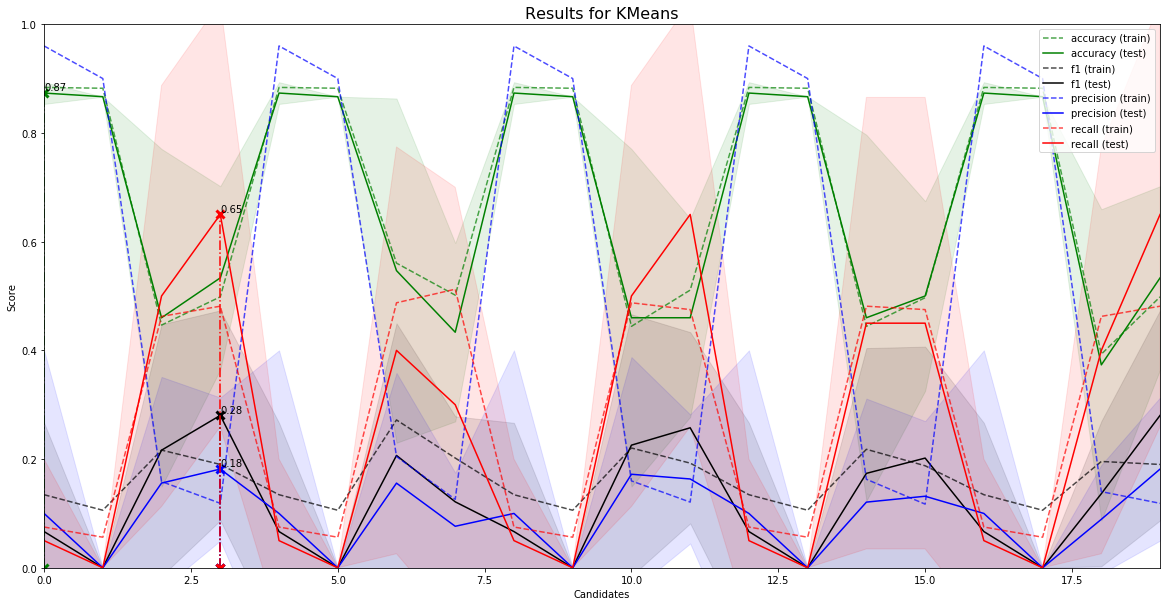


Analyzing RandomForestClassifier...
Fitting 10 folds for each of 3240 candidates, totalling 32400 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [118]:
# Task 5: Tune your classifier to achieve better than .3 precision and recall
# using our testing script. Check the tester.py script in the final project
# folder for details on the evaluation method, especially the test_classifier
# function. Because of the small dataset size, the test script uses stratified
# shuffle split cross validation, so that's what we'll use here as well.
# For more info:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
cv_strategy = StratifiedShuffleSplit(n_splits=10, random_state=42)
# We define all the scoring metrics we want to measure. Recall will be the one
# used to select the best set of parameters, and refit the identifier, because
# in this case false positives are far better than false negatives, since we
# don't want to risk missing ani pois. Recall needs to be the first metric on
# the list, because get_best_estimator assumes the one in that position to be
# the main metric to evaluate the select estimator.
start_time = time()
metrics = ['accuracy', 'recall', 'precision', 'f1']
results, best_estimator = get_best_estimator(features, labels, pipelines,
                                             cv_strategy, metrics)
get_best_estimator_metrics(results, metrics)
training_time = round(time() - start_time, 3)
print('\nTotal training time: {} s. \nBest Overall Estimator Found:\n{}\n'
      .format(training_time, best_estimator))


# # TODO fix this. ¿Maybe refit is needed here before getting results?
# # results = DataFrame.from_dict(best_estimator.cv_results_)
# # results.head()

# # Task 6: Dump your classifier, dataset, and features_list so anyone can check
# # your results. You do not need to change anything below, but make sure that
# # the version of poi_id.py that you submit can be run on its own and generates
# # the necessary .pkl files for validating your results.
# dump_classifier_and_data(best_estimator, enron_data, enron_feature_list)